#Final Project - Weather Wiz

### Overview
  Weather Wiz is a cutting-edge machine learning project designed to predict weather patterns, specifically temperature and radiation, using 25 years of historical data collected from meteorological stations across Israel by the Israel Meteorological Service (IMS). The data was sampled every 10 minutes daily and later aggregated into a daily template.

# Connect to Google drive

In [40]:
# -------------------------------------------------------------------
# Connect to Google drive
# -------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importing Needed Packages

In [41]:
# -------------------------------------------------------------------
# Importing Needed Packages
# -------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import random
import requests
import json

# Scikit-learn for Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import radius_neighbors_graph


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# if there's a problem with the import.
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Miscellaneous
from collections import Counter

# -------------------------------------------------------------------
# Confirmation of successful imports
# -------------------------------------------------------------------
print("All imports are successful!")

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
All imports are successful!


In [42]:
# -------------------------------------------------------------------
# Set Seeds for Reproducibility & Device Management
# -------------------------------------------------------------------

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# --------------------------- Helper Functions ---------------------------

In [43]:
# -------------------------------------------------------------------
# Helper Functions for Evaluation & Plotting
# -------------------------------------------------------------------

def median_absolute_percentage_error(y_true, y_pred, delta=1e-3, epsilon=1e-6):
    """
    Compute a modified median absolute percentage error (MdAPE) that ignores
    samples with |y_true| less than delta.

    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        delta (float): Threshold below which a true value is considered too close to zero.
        epsilon (float): Small constant to prevent division by zero.

    Returns:
        float: The median absolute percentage error calculated only on samples with |y_true| > delta.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Create a mask for valid samples
    mask = np.abs(y_true) > delta
    if np.sum(mask) == 0:
        return np.nan  # or 0, depending on your preference
    relative_errors = np.abs((y_true[mask] - y_pred[mask]) / np.maximum(np.abs(y_true[mask]), epsilon)) * 100
    return np.median(relative_errors)


def evaluate_model(model_name, y_true, y_pred):
    """
    Evaluate a model's performance using various metrics.

    Parameters:
        model_name (str): Name of the model.
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        tuple: (mae, mse, r2, mdape)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  MdAPE: {mdape:.4f}%\n")
    return mae, mse, r2, mdape


def train_and_evaluate(model, model_name, train_X, test_X, train_y, test_y):
    """
    Train a scikit-learn model and evaluate its performance.

    This function fits the given model on the training data, makes predictions
    on the test data, evaluates the predictions, and plots actual vs. predicted values.

    Parameters:
        model: scikit-learn model instance.
        model_name (str): Name of the model (for printing and plotting).
        train_X: Training feature data.
        test_X: Testing feature data.
        train_y: Training target values.
        test_y: Testing target values.

    Returns:
        tuple: (mae, mse, r2, MdAPE, predictions)
    """
    # Train the model
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    predictions = np.round(predictions, 2)

    # Evaluate the model
    mae, mse, r2, mdape = evaluate_model(model_name, test_y, predictions)

    # Plot Actual vs. Predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(test_y, predictions, alpha=0.6, label="Predicted vs Actual")
    plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'r--', label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.legend()
    plt.show()

    return mae, mse, r2, mdape, predictions


def plot_series(test_obs, test_preds, model_name, fold_idx):
    test_obs.index = pd.to_datetime(test_obs.index, utc=True)
    test_preds = pd.Series(test_preds, index=test_obs.index)
    fig, ax = plt.subplots(figsize=(20, 6))

    # Scatter plot for observations
    ax.scatter(test_obs.index, test_obs, label="Observation", color="blue", s=50, marker="o")

    # Scatter plot for predictions
    ax.scatter(test_obs.index, test_preds, label="Prediction", color="orange", s=50, marker="x")

    ax.set_title(f"{model_name}, Fold: {fold_idx} - Observation vs Prediction")
    ax.legend()
    ax.set_xlabel("Day")
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()


def plot_series_auto(test_obs, test_preds, model_name, fold_idx, gap_threshold=pd.Timedelta("1d"), min_points=30):
    # Ensure index is datetime
    print(test_obs.head())
    test_obs.index = pd.to_datetime(test_obs.index)
    test_preds = pd.Series(test_preds, index=test_obs.index)

    # Compute time differences between consecutive timestamps
    time_diffs = test_obs.index.to_series().diff().fillna(pd.Timedelta(0))
    # Identify the start of new segments where gap exceeds threshold
    new_seg = time_diffs > gap_threshold

    segments = []
    current_seg = []
    for ts, is_new in zip(test_obs.index, new_seg):
        if is_new and current_seg:
            segments.append(current_seg)
            current_seg = [ts]
        else:
            current_seg.append(ts)
    if current_seg:
        segments.append(current_seg)

    # Plot each segment if it has enough points
    for seg in random.sample(segments, 3):
        if len(seg) >= min_points:
            seg_obs = test_obs.loc[seg]
            seg_preds = test_preds.loc[seg]
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.scatter(seg_obs.index, seg_obs, label="Observation", color="blue", s=50, marker="o")
            ax.scatter(seg_obs.index, seg_preds, label="Prediction", color="orange", s=50, marker="x")
            ax.set_title(f"{model_name}, Fold: {fold_idx} - Continuous Segment")
            ax.legend()
            ax.set_xlabel("Time")
            ax.grid(True)
            plt.xticks(rotation=45)
            plt.show()


# -------------------------------------------------------------------
# Helper Functions for Creating Sequences & DataLoaders
# -------------------------------------------------------------------
def create_time_series_sequences(features, targets, sequence_length):
    """
    Create sequences of features and corresponding target values for time series forecasting.

    Parameters:
        features (array-like, pd.DataFrame, or pd.Series):
            The input features used for prediction.
        targets (array-like, pd.Series, or list):
            The target values that you want to predict.
        sequence_length (int):
            The number of time steps to include in each input sequence (i.e., the look-back window).

    Returns:
        tuple: A tuple (X_sequences, y_sequences) where:
            - X_sequences is a NumPy array of shape (num_samples, sequence_length, num_features)
            - y_sequences is a NumPy array of shape (num_samples,)
    """
    if isinstance(features, (pd.DataFrame, pd.Series)):
        features = features.values
    if isinstance(targets, pd.Series):
        targets = targets.values
    X_sequences, y_sequences = [], []
    for i in range(len(features) - sequence_length):
        X_sequences.append(features[i: i + sequence_length])
        y_sequences.append(targets[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)


def create_data_loader(X, y, batch_size=32, shuffle=True):
    """
    Create a PyTorch DataLoader from the given input features and target values.

    Parameters:
        X (array-like):
            The input features (e.g., a NumPy array).
        y (array-like):
            The target values.
        batch_size (int, optional):
            The number of samples per batch. Default is 32.
        shuffle (bool, optional):
            Whether to shuffle the data. Default is True.

    Returns:
        torch.utils.data.DataLoader: A DataLoader object for the provided data.
    """
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# --------------------------- Data Preparation & Time series split ---------------------------



In [44]:
# -------------------------------------------------------------------
# Updated Data Preparation Functions
# -------------------------------------------------------------------

def custom_time_series_split(df, n_splits, test_size, y):
    """
    Custom time series split function to split the data into training and testing sets.

    This function splits the input DataFrame into multiple training and testing sets using a time
    series cross-validation strategy. It first drops certain columns (e.g., station identifiers and
    other metadata) and then uses sklearn's TimeSeriesSplit to generate folds. For each fold, it scales
    the features with MinMaxScaler and records the original datetime indices.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing time series data with a 'datetime' column.
        n_splits (int): Number of splits (folds) for time series cross-validation.
        test_size (int): Number of samples to include in the test set for each split.
        y (str): Name of the target variable column in the DataFrame.

    Returns:
        tuple: A tuple containing:
            - X_train_list (list): List of scaled training feature arrays for each fold.
            - y_train_list (list): List of training target Series for each fold.
            - X_test_list (list): List of scaled testing feature arrays for each fold.
            - y_test_list (list): List of testing target Series for each fold.
            - train_idx_list (list): List of training indices (original datetime indices) for each fold.
            - test_idx_list (list): List of testing indices (original datetime indices) for each fold.
            - df (pd.DataFrame): The original input DataFrame.
    """
    X = df.drop(columns=['station_id', 'Station Name', 'Region ID', 'min', 'max', 'TD',
                         'range', 'range_days', 'range_days_round', y], errors="ignore")
    y = df[y].copy()

    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []
    train_idx_list, test_idx_list = [], []

    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"Fold {fold + 1}: TRAIN indices=[{train_index[0]}..{train_index[-1]}], TEST=[{test_index[0]}..{test_index[-1]}]")

        # Use .iloc on X and y but preserve the index:
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        # Save the original datetime indexes instead of the integer positions:
        train_idx_list.append(X_train.index)
        test_idx_list.append(X_test.index)

        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_list.append(X_train_scaled)
        y_train_list.append(y_train)
        X_test_list.append(X_test_scaled)
        y_test_list.append(y_test)

    return X_train_list, y_train_list, X_test_list, y_test_list, train_idx_list, test_idx_list, df


def get_data_from_api(url_request):
    """
    Fetch data from the IMS API.

    This function sends a GET request to the specified API endpoint using an authorization header.
    It then parses the response JSON into a Python object.

    Parameters:
        url_request (str): The API endpoint URL from which to fetch data.

    Returns:
        dict or list: The parsed JSON response from the API.
    """
    headers = {'Authorization': 'ApiToken'} #for security the token have been removed for final code
    response = requests.request("GET", url_request, headers=headers)
    data = json.loads(response.text.encode('utf8'))

    return data

def get_df_from_json(data):
    """
    Convert JSON data from the API into a Pandas DataFrame.

    Extracts relevant fields from the JSON object (such as station_id, datetime, channel, and value)
    and pivots the data so that each channel becomes a separate column. The DataFrame is then reset
    to have a default integer index.

    Parameters:
        data (dict): JSON data containing sensor readings. Expected to include a 'data' key where each
                     element contains a 'channels' list with sensor information.

    Returns:
        pd.DataFrame: A DataFrame with rows corresponding to individual measurements and columns representing
                      different channels.
    """
    df_rows = []
    # for station_id, data in data:
    for row in data['data']:
        for channel in row['channels']:
            channel_name = channel['name']
            value = channel['value']
            df_rows.append(
                {"station_id":  data['stationId'],
                    "datetime": row['datetime'],
                    "channel": channel_name,
                    "value": value
                    }
            )
    df = pd.DataFrame(df_rows)

    df = df.pivot(index=['station_id', 'datetime'], columns="channel", values="value")
    df.columns.name = None
    df = df.reset_index()
    return df


def collect_data_to_df(stations=None, start=None, end=None, url=None):
    """
    Collect sensor data from the IMS API and return it as a DataFrame.

    If a direct URL is provided, data is fetched from that endpoint. Otherwise, the function iterates
    through the provided station IDs, builds the API URL using the specified start and end dates, retrieves
    the data, and converts it into a DataFrame.

    Parameters:
        stations (list, optional): List of station IDs to fetch data for. Default is None.
        start (str): Start date for the data query in 'YYYY-MM-DD' format.
        end (str): End date for the data query in 'YYYY-MM-DD' format.
        url (str, optional): Direct URL for the API request. If provided, overrides the station, start, and end parameters.

    Returns:
        pd.DataFrame: DataFrame containing the sensor data retrieved from the API.
    """
    if url is None:
        for station_id in stations:
            url = f"https://api.ims.gov.il/v1/envista/stations/{station_id}/data?from={start}&to={end}"
            #print(url)
            data = get_data_from_api(url)
            df = get_df_from_json(data)
    else:
        data = get_data_from_api(url)
        df = get_df_from_json(data)

    return df

def generate_datelist(start, end):
    """
    Generate a list of monthly date ranges between the start and end dates.

    This function creates a list of tuples, each representing a monthly interval. It uses pandas' date_range
    with both month-end ('ME') and month-start ('MS') frequencies, then formats the dates as strings ('YYYY-MM-DD')
    and orders the list in reverse chronological order.

    Parameters:
        start (str or datetime-like): The start date for the interval.
        end (str or datetime-like): The end date for the interval.

    Returns:
        list of tuple: A list of tuples where each tuple contains two strings representing the start and end dates
                       of a month.
    """
    datelist = list(zip(pd.date_range(start=start,end=end, freq='ME', inclusive='both').tolist(),
                        pd.date_range(start=start,end=end, freq="MS", inclusive='both').tolist()
                        )
                    )
    datelist = list(reversed([(i.strftime("%Y-%m-%d"), j.strftime("%Y-%m-%d")) for i,j in datelist]))
    return datelist

def populate_date_by_range(current_df, datelist, stations=[22]):
    """
    Populate a DataFrame with data over multiple monthly ranges.

    For each station provided and for each date range in the datelist, this function queries the IMS API
    (using the collect_data_to_df function) to retrieve data for that month. The results for each query are
    concatenated with the current DataFrame.

    Parameters:
        current_df (pd.DataFrame): The DataFrame to which new data will be appended.
        datelist (list of tuple): A list of (start_date, end_date) tuples representing monthly intervals.
        stations (list, optional): List of station IDs to fetch data for. Defaults to [22].

    Returns:
        pd.DataFrame: The updated DataFrame containing concatenated data for all specified stations and date ranges.
    """
    for station in tqdm.tqdm(stations):
        for start, end in datelist:
            try:
                df_one_month = collect_data_to_df(stations=[station], start=start, end=end)

                current_df = pd.concat([current_df, df_one_month], axis=0, ignore_index=True, sort=False)
            except Exception as e:
                continue
        # uncomment to write file
        #current_df.to_csv('location', mode='w', header=True, index=False)
    return current_df


# # Fallaten Metadata JSON
def flatten_JSON(metadata):
    """
    Flatten nested metadata JSON into a list of dictionaries.

    Processes a nested JSON structure containing regions, each with a list of stations and monitors,
    and extracts key metadata into a flat list of dictionaries. This makes it easier to work with the
    metadata in a tabular format.

    Parameters:
        metadata (list): A list of region dictionaries, where each region contains nested station and monitor data.

    Returns:
        list of dict: A list where each dictionary holds flattened metadata, including region information,
                      station details, and monitor attributes.
    """
    metadata_rows = []
    for region in metadata:
        region_id = region['regionId']
        region_name = region['name']
        for station in region['stations']:
            station_id = station['stationId']
            station_name = station['name']
            short_name = station['shortName']
            latitude = station['location']['latitude']
            longitude = station['location']['longitude']
            for monitor in station['monitors']:
                metadata_rows.append({
                    'Region ID': region_id,
                    'Region Name': region_name,
                    'Station ID': station_id,
                    'Station Name': station_name,
                    'Short Name': short_name,
                    'Latitude': latitude,
                    'Longitude': longitude,
                    'Monitor Channel ID': monitor['channelId'],
                    'Monitor Name': monitor['name'],
                    'Monitor Alias': monitor['alias'],
                    'Units': monitor['units'],
                    'Active': monitor['active']
                })
    return metadata_rows


def prepare_data(df, n_splits, test_size, y):
    """
    Prepare and split data for time series modeling.

    This function performs several data cleaning and preparation steps. These steps include filtering rows
    based on valid ranges for physical measurements, scaling relative humidity, converting the datetime column,
    and sorting the DataFrame. Although additional feature engineering steps are included in the code as comments,
    the primary output of this function is to prepare the data for time series cross-validation by calling
    custom_time_series_split.

    Parameters:
        df (pd.DataFrame): Input DataFrame that must contain a 'datetime' column.
        n_splits (int): Number of splits (folds) for time series cross-validation.
        test_size (int): Number of samples to include in the test set for each fold.
        y (str): Name of the target variable column.

    Returns:
        tuple: The output from custom_time_series_split, which includes:
            - X_train_list (list): List of scaled training feature arrays.
            - y_train_list (list): List of training target Series.
            - X_test_list (list): List of scaled testing feature arrays.
            - y_test_list (list): List of testing target Series.
            - train_idx_list (list): List of training index arrays.
            - test_idx_list (list): List of testing index arrays.
            - df (pd.DataFrame): The processed DataFrame.
    """

    # metadata = get_data_from_api("https://api.ims.gov.il/v1/envista/regions/")
    # metadata_rows = flatten_JSON(metadata)
    # meta_df = pd.DataFrame(metadata_rows)

    # stations = meta_df.loc[meta_df['Active']==True][['Station Name', 'Station ID', 'Region ID','Latitude','Longitude']].drop_duplicates()#.sort_values(['Latitude','Longitude'])


    # df = df.merge(stations, left_on='station_id', right_on='Station ID',right_index=False ).drop(columns='Station ID')
    # df = df.merge(date_range, on='station_id')
    # df['range_days_round'] = df['range_days'].round(-3)


    # df = df.dropna(subset=['TG','RH', 'Grad', 'Rain'])
    # df['Rain'].fillna(0, inplace=True)

    # df = df.query("RH >= 0 or RH <= 100")
    # df = df.query("TD >= 0 or TD <= 40")

    # # replace negative values with null for physical features
    # for col in df.select_dtypes(include=['float64']):
    #     df.loc[:, col] = df.loc[:, col].apply(lambda x: np.nan if x < 0 else x).copy()

    # ############# Feature Engineering ###############

    # df['Time'] = pd.to_datetime(df['datetime'], utc=True).dt.hour
    # # sin and cos of the time can help the model understand the cyclical patterns better
    # df['hour_sin'] = df['Time'].apply(lambda hour: np.sin(2 * np.pi * hour / 24))
    # df['hour_cos'] = df['Time'].apply(lambda hour: np.cos(2 * np.pi * hour / 24))

    # # create vector of wind from Wind Speed and Wind Direction
    # df['wind_x'] = df['WS'] * np.cos(df['WD'] * np.pi / 180)
    # df['wind_y'] = df['WS'] * np.sin(df['WD'] * np.pi / 180)

    # # drop all the column which don't have enough data in them. they are relevant for very few stations therefore not relevant to impute and fill the missing.
    # df.drop(columns=['DiffR', 'NIP', 'BP','TW', 'WS1mm','WS1mm','Ws10mm','WSmax','WDmax', 'STDwd','TDmax','TDmin','Grad','WD'
    #                     ,'Id','Vbatt', 'Rain_1_min','STAB', 'RadAgro', 'STDwd60m', 'Wd60m', 'Ws60m', 'wd60mmax', 'ws60mmax'
    #                 ], inplace=True)

    # #drop the nulls
    # df.dropna(inplace=True, subset=['TG','RH','Rain', 'Latitude',  'WS', 'Time','TD'])

    print(f"Using test_size={test_size} ({(test_size / len(df)) * 100:.1f}% of dataset)")
    print(df.shape)
    df = df.query("0 <= RH <= 100 and -15 <= TD <= 50 and -15 <= TG <= 50 and 0 <= Rain <= 10 and -100 <= WS <= 200").copy()

    df.loc[:, "RH"] = df["RH"] / 100.0
    df.loc[:, "datetime"] = pd.to_datetime(df["datetime"], utc=True, errors="coerce")


    df["RH"] = df["RH"] / 100.0
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
    df = df.sort_values('datetime')
    print(df.shape)
    df.set_index('datetime', inplace=True)

    return custom_time_series_split(df, n_splits, test_size, y)

# --------------------------- Linear Models (Benchmark) ---------------------------

In [45]:
# Linear Regression - No regularization
# Formula: y = Xw + b
def linear_regression_model(train_X, test_X, train_y, test_y, **kwargs):
    print("\n--- Training Linear Regression Model ---")
    model = LinearRegression(**kwargs)
    return train_and_evaluate(model, "Linear Regression", train_X, test_X, train_y, test_y)

# Ridge Regression - L2 regularization
# Formula: Minimize ||y - Xw||^2 + alpha * ||w||^2
def ridge_regression_model(train_X, test_X, train_y, test_y, **kwargs):
    print("\n--- Training Ridge Regression Model ---")
    model = Ridge(**kwargs)
    return train_and_evaluate(model, "Ridge Regression", train_X, test_X, train_y, test_y)

# Lasso Regressio - L1 regularization
# Formula: Minimize ||y - Xw||^2 + alpha * ||w||_1
def lasso_regression_model(train_X, test_X, train_y, test_y, **kwargs):
    print("\n--- Training Lasso Regression Model ---")
    model = Lasso(**kwargs)
    return train_and_evaluate(model, "Lasso Regression", train_X, test_X, train_y, test_y)

# --------------------------- Random Forest Model ---------------------------


In [46]:
def random_forest_model(train_X, test_X, train_y, test_y, **kwargs):
    print("\n--- Training Random Forest Model ---")
    model = RandomForestRegressor(**kwargs)
    return train_and_evaluate(model, "Random Forest", train_X, test_X, train_y, test_y)

# --------------------------- LSTM Model ---------------------------


In [47]:
"""
LSTM for Weather Forecasting
"""
# -------------------------------------------------------------------
# LSTM Model (WeatherForecastLSTM)
# -------------------------------------------------------------------
class WeatherForecastLSTM(nn.Module):
    def __init__(self, input_dim, hidden_units=32, lstm_layers=2, dropout_rate=0.0):
        """
        A simplified LSTM model with at least 2 layers.

        Parameters:
            input_dim (int): Number of input features.
            hidden_units (int): Number of hidden units.
            lstm_layers (int): Number of LSTM layers (default is 2).
            dropout_rate (float): Dropout rate (applied if lstm_layers > 1).
        """
        super(WeatherForecastLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_units,
            num_layers=lstm_layers,
            dropout=dropout_rate if lstm_layers > 1 else 0,
            batch_first=True,
            bidirectional=False  # Single-direction for speed.
        )
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_output = self.fc(lstm_out[:, -1, :])
        return final_output

# -------------------------------------------------------------------
# Training Function for LSTM (train_lstm_model)
# -------------------------------------------------------------------
def train_lstm_model(model, train_loader, val_loader, loss_function, optimizer,
                     epochs=5, save_path="best_lstm_model.pth"):

    device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device_local)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device_local), batch_y.to(device_local)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_function(predictions, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device_local), batch_y.to(device_local)
                predictions = model(batch_X)
                loss = loss_function(predictions, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"LSTM Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print("New best LSTM model saved.")

    model.load_state_dict(torch.load(save_path))
    return model

# -------------------------------------------------------------------
# Training and Evaluation Interface for LSTM (train_and_evaluate_lstm_model)
# -------------------------------------------------------------------
def train_and_evaluate_lstm_model(train_X, test_X, train_y, test_y, sequence_length=50, **kwargs):
    """
    Interface for training and evaluating the LSTM model.

    Parameters:
        train_X, test_X: Input features.
        train_y, test_y: Target values.
        sequence_length (int): Look-back window (default 50).
        kwargs: Additional hyperparameters:
            - batch_size (default 128)
            - hidden_units (default 32)
            - lstm_layers (default 2)
            - dropout_rate (default 0.0)
            - learning_rate (default 0.001)
            - epochs (default 5)

    Returns:
        tuple: (mae, mse, r2, mdape, predictions)
    """
    batch_size = kwargs.get("batch_size", 128)
    hidden_units = kwargs.get("hidden_units", 32)
    lstm_layers = kwargs.get("lstm_layers", 2)
    dropout_rate = kwargs.get("dropout_rate", 0.0)
    learning_rate = kwargs.get("learning_rate", 0.001)
    epochs = kwargs.get("epochs", 5)

    # Create sequences
    train_X_seq, train_y_seq = create_time_series_sequences(train_X, train_y, sequence_length)
    test_X_seq, test_y_seq = create_time_series_sequences(test_X, test_y, sequence_length)

    # Split training sequences into training and validation (80/20 split)
    split_index = int(len(train_X_seq) * 0.8)
    train_loader = create_data_loader(train_X_seq[:split_index], train_y_seq[:split_index], batch_size=batch_size, shuffle=True)
    val_loader = create_data_loader(train_X_seq[split_index:], train_y_seq[split_index:], batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(test_X_seq, test_y_seq, batch_size=batch_size, shuffle=False)

    input_dim = train_X_seq.shape[2]
    model = WeatherForecastLSTM(input_dim, hidden_units, lstm_layers, dropout_rate)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = train_lstm_model(model, train_loader, val_loader, loss_function, optimizer, epochs=epochs, save_path="best_lstm_model.pth")
    model.eval()
    predictions = []
    device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.to(device_local)
            batch_preds = model(batch_X)
            predictions.extend(batch_preds.squeeze().cpu().numpy())

    return evaluate_model("LSTM", test_y_seq, predictions) + (predictions,)

# --------------------------- Graph Neural Network Model ---------------------------



In [48]:
# -----------------------------------------------------------------------------
# Helper: Create Graph Data with Window
# -----------------------------------------------------------------------------
def compute_geographical_edges(lat_array, lon_array, threshold=0.01):
    """
    Compute geographic edges for nodes based on their latitude and longitude
    using a sparse radius_neighbors_graph approach.

    Two nodes are connected if the Euclidean distance between them is below threshold.
    This implementation is more memory efficient than a double nested loop.

    Args:
        lat_array (np.array): Array of latitudes for the nodes.
        lon_array (np.array): Array of longitudes for the nodes.
        threshold (float): Distance threshold.

    Returns:
        torch.Tensor: Edge indices tensor of shape [2, num_edges]
    """
    # Stack coordinates into an array of shape (n_samples, 2)
    coords = np.column_stack((lat_array, lon_array))
    # Compute a sparse graph (CSR matrix) where nonzero entries indicate connectivity
    graph = radius_neighbors_graph(coords, radius=threshold, mode='connectivity', include_self=False)
    # Get the row and column indices of the nonzero entries
    rows, cols = graph.nonzero()
    # Combine the row and column indices into an edge index array
    edge_index = np.vstack((rows, cols))
    return torch.tensor(edge_index, dtype=torch.long)


def create_graph_data_with_window(X_train, y_train, X_test, y_test, window, extra_edges, geo_threshold=0.01):
    """
    Creates graph data objects from time series data.
    By default, it builds sequential edges over a sliding window.
    If extra_edges is provided (a dictionary with keys "train" and "test" containing tuples
    of (latitude_array, longitude_array)), then additional geographic edges are computed
    (using a distance threshold) and concatenated with the sequential edges.

    Args:
        X_train, X_test: Input feature arrays or DataFrames.
        y_train, y_test: Target values.
        window (int): Number of subsequent nodes to connect (for sequential/temporal edges).
        extra_edges (dict): Dictionary with keys "train" and "test". Each value should be a tuple
                            (lat_array, lon_array) for the corresponding split.
        geo_threshold (float): Threshold for geographic proximity.

    Returns:
        train_data, test_data: Two torch_geometric.data.Data objects containing:
            - x: the feature tensor.
            - edge_index: the combined edge index (sequential and geographic).
            - y: the target tensor.
    """
    # Convert inputs to tensors
    X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32)
    X_test_tensor  = torch.tensor(np.array(X_test), dtype=torch.float32)
    y_test_tensor  = torch.tensor(np.array(y_test), dtype=torch.float32)

    # Build sequential edge indices for training data
    train_edge_list = []
    num_train_nodes = X_train_tensor.size(0)
    for i in range(num_train_nodes):
        for j in range(1, window + 1):
            if i + j < num_train_nodes:
                train_edge_list.append([i, i+j])
    if train_edge_list:
        train_edge_index = torch.tensor(train_edge_list, dtype=torch.long).t().contiguous()
    else:
        train_edge_index = torch.empty((2, 0), dtype=torch.long)

    # Build sequential edge indices for test data
    test_edge_list = []
    num_test_nodes = X_test_tensor.size(0)
    for i in range(num_test_nodes):
        for j in range(1, window + 1):
            if i + j < num_test_nodes:
                test_edge_list.append([i, i+j])
    if test_edge_list:
        test_edge_index = torch.tensor(test_edge_list, dtype=torch.long).t().contiguous()
    else:
        test_edge_index = torch.empty((2, 0), dtype=torch.long)

    # If extra_edges are provided, compute geographic edges using the optimized function.
    if extra_edges is not None:
        if "train" in extra_edges:
            train_lat, train_lon = extra_edges["train"]
            extra_train_edges = compute_geographical_edges(train_lat, train_lon, threshold=geo_threshold)
            if extra_train_edges.numel() > 0:
                train_edge_index = torch.cat([train_edge_index, extra_train_edges], dim=1) if train_edge_index.numel() > 0 else extra_train_edges
        if "test" in extra_edges:
            test_lat, test_lon = extra_edges["test"]
            extra_test_edges = compute_geographical_edges(test_lat, test_lon, threshold=geo_threshold)
            if extra_test_edges.numel() > 0:
                test_edge_index = torch.cat([test_edge_index, extra_test_edges], dim=1) if test_edge_index.numel() > 0 else extra_test_edges

    # Create torch_geometric Data objects
    from torch_geometric.data import Data
    train_data = Data(x=X_train_tensor, edge_index=train_edge_index, y=y_train_tensor)
    test_data = Data(x=X_test_tensor, edge_index=test_edge_index, y=y_test_tensor)
    return train_data, test_data


# -----------------------------------------------------------------------------
# Best GNN Model: GraphNeuralNetwork
# -----------------------------------------------------------------------------
class GraphNeuralNetwork(nn.Module):
    def __init__(self, num_features, hidden_dim=128, dropout=0.3, negative_slope=0.01):
        """
        A robust GNN model that uses three GCNConv layers with residual connections.
        Batch normalization and LeakyReLU activations are applied for improved stability.
        """
        super(GraphNeuralNetwork, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.negative_slope = negative_slope

    def forward(self, x, edge_index):
        # First layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1, negative_slope=self.negative_slope)
        x1 = self.dropout(x1)

        # Second layer
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2, negative_slope=self.negative_slope)
        x2 = self.dropout(x2)
        # Residual connection: add the output of the first layer to the second layer
        x2 = x2 + x1

        # Third layer
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.leaky_relu(x3, negative_slope=self.negative_slope)
        x3 = self.dropout(x3)
        # Residual connection: add the result from the previous block
        x3 = x3 + x2

        out = self.fc(x3)
        return out.squeeze()

# -----------------------------------------------------------------------------
# Plot Function for Training and Validation Loss
# -----------------------------------------------------------------------------
def plot_gnn_loss(train_losses, val_losses):
    """
    Plots the GNN training and validation loss curves.

    Parameters:
        train_losses (list): List of training loss values (MSE) for each epoch.
        val_losses (list): List of validation loss values (MSE) for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.scatter(epochs, train_losses, marker='o', label="Training Loss")
    plt.scatter(epochs, val_losses, marker='o', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("GNN Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------------------------------------------------------
# Updated Training Function for GNN (with Validation Loss Plotting and Windows)
# -----------------------------------------------------------------------------
def train_gnn(model, train_data, val_data, epochs=30, lr=0.001):
    """
    Trains the GNN model on the provided train_data and evaluates on val_data.
    Records both training and validation losses and plots the loss curves after training.

    Parameters:
        model (nn.Module): The GNN model.
        train_data (Data): A torch_geometric.data.Data object for training (with attributes: x, edge_index, y).
        val_data (Data): A torch_geometric.data.Data object for validation.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.

    Returns:
        model: The trained GNN model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_data = train_data.to(device)
    val_data = val_data.to(device)

    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    loss_function = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        # Forward pass on training data
        predictions = model(train_data.x, train_data.edge_index)
        loss = loss_function(predictions, train_data.y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_data.x, val_data.edge_index)
            val_loss = loss_function(val_predictions, val_data.y)
        val_losses.append(val_loss.item())

        print(f"GNN Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

    # Plot the training and validation loss curves
    plot_gnn_loss(train_losses, val_losses)

    return model

# -----------------------------------------------------------------------------
# (Optional) Evaluation Function for GNN
# -----------------------------------------------------------------------------
def evaluate_gnn_final(model, test_data, test_y):
    """
    Evaluates the trained GNN model on the test data and prints performance metrics.

    Parameters:
        model (nn.Module): The trained GNN model.
        test_data (Data): A torch_geometric.data.Data object for testing.
        test_y (array-like): The ground truth target values for the test data.

    Returns:
        tuple: (mae, mse, r2, mdape, predictions)
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        predictions = model(test_data.x.to(device), test_data.edge_index.to(device)).cpu().numpy()
    mae = mean_absolute_error(test_y, predictions)
    mse = mean_squared_error(test_y, predictions)
    r2 = r2_score(test_y, predictions)
    mdape = median_absolute_percentage_error(test_y, predictions)
    print("GNN Performance:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  MdAPE: {mdape:.4f}%")
    return mae, mse, r2, mdape, predictions

# -----------------------------------------------------------------------------
# Wrapper Function for End-to-End Training and Evaluation of GNN (with Window Parameter)
# -----------------------------------------------------------------------------
def train_and_evaluate_gnn_model(train_X, test_X, train_y, test_y,  window=5, unique_edge=None, **kwargs):
    """
    Prepares the graph data, trains the GNN model, and evaluates it.
    This function now includes a 'window' parameter to control the window size
    for creating the graph structure from the time series data.

    Parameters:
        train_X: Training features (numpy array or DataFrame).
        test_X: Testing features.
        train_y: Training target values.
        test_y: Testing target values.
        station_ids: Optional station IDs for creating graph edges.
        window (int): The window size to use when constructing the graph.
        kwargs: Hyperparameters for the GNN model and training.
            Expected keys include:
                - hidden_dim (default 128)
                - dropout (default 0.3)
                - learning_rate (default 0.001)
                - epochs (default 30)

    Returns:
        tuple: (mae, mse, r2, mdape, predictions)
    """
    hidden_dim = kwargs.get("hidden_dim", 256)
    dropout = kwargs.get("dropout", 0.3)
    learning_rate = kwargs.get("learning_rate", 0.001)
    epochs = kwargs.get("epochs", 50)

    print("\n--- Preparing Graph Data ---")
    # Use the window parameter in the graph data creation
    train_data, test_data = create_graph_data_with_window(train_X, train_y, test_X, test_y, window, unique_edge)

    print("\n--- Training GNN ---")
    model = GraphNeuralNetwork(num_features=train_X.shape[1], hidden_dim=hidden_dim, dropout=dropout)
    model = train_gnn(model, train_data, test_data, epochs=epochs, lr=learning_rate)

    print("\n--- Evaluating GNN ---")
    mae, mse, r2, mdape, predictions = evaluate_gnn_final(model, test_data, test_y)
    return mae, mse, r2, mdape, predictions

# --------------------------- EDA ---------------------------
## EVALUATION METRICS:
## **1. Mean Absolute Error (MAE)**
- Measures the average absolute difference between predictions and actual values.
- **Ideal:** Lower is better (0 = perfect predictions).  
---

## **2. Mean Squared Error (MSE)**
- Calculates the average squared differences, penalizing larger errors.
- **Ideal:** Lower is better (0 = perfect predictions).  
---

## **3. R² Score (Coefficient of Determination)**
- Indicates how well the model explains variance in the target variable.
- **Ideal:** Higher is better (**1** = perfect fit, **0** = baseline, negative = poor fit).  
---

## **4. Median Absolute Percentage Error (MdAPE)**
- Measures the average percentage error, providing a relative error measure.
- **Ideal:** Lower is better (0% indicates perfect predictions).  
---

## **Ideal Metric Summary**

| **Metric**   | **Goal**            | **Description**                   |
|-------------|---------------------|-----------------------------------|
| **MAE**     | Lower is better     | Average absolute error           |
| **MSE**     | Lower is better     | Penalizes large errors more      |
| **R² Score** | Higher is better   | Variance explained by the model  |
| **MdAPE**    | Lower is better     | Median Absolute Percentage Error |


In [49]:
def perform_eda(df):
    """
    Perform exploratory data analysis (EDA) on the raw weather dataset.

    This function:
      - Converts the 'datetime' column to a datetime object.
      - Prints basic info and descriptive statistics.
      - Plots histograms of key variables.
      - Creates a time series plot of the temperature (TG).
      - Shows a correlation heatmap for numeric features.
      - Visualizes missing values.

    Parameters:
        df (pd.DataFrame): The raw weather dataframe.

    Returns:
        pd.DataFrame: The dataframe with the 'datetime' column converted.
    """
    # Convert 'datetime' to datetime objects (if not already)
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)

    # Print basic information
    print("DataFrame shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("First 5 rows:")
    print(df.head())

    # Descriptive statistics for numeric columns
    print("\nDescriptive Statistics:")
    print(df.describe())

    # Plot histogram of Temperature (TG)
    if 'TG' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['TG'].dropna(), bins=30, kde=True, color="salmon")
        plt.title("Distribution of Temperature (TG)")
        plt.xlabel("Temperature (°C)")
        plt.ylabel("Frequency")
        plt.show()

    # Plot histogram of Relative Humidity (RH)
    if 'RH' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['RH'].dropna(), bins=30, kde=True, color="skyblue")
        plt.title("Distribution of Relative Humidity (RH)")
        plt.xlabel("Relative Humidity")
        plt.ylabel("Frequency")
        plt.show()

    # Plot histogram of Rainfall
    if 'Rain' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Rain'].dropna(), bins=30, kde=False, color="lightgreen")
        plt.title("Distribution of Rainfall")
        plt.xlabel("Rainfall (mm)")
        plt.ylabel("Frequency")
        plt.show()

    # Plot a time series of Temperature (TG)
    if 'datetime' in df.columns and 'TG' in df.columns:
        # Work on a copy to avoid modifying the original dataframe
        df = df.copy()

        # Convert the datetime column and drop rows with NaT in datetime or TG
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
        df = df.dropna(subset=['datetime', 'TG'])

        # Sort the data by datetime
        df_sorted = df.sort_values(by='datetime')

        plt.figure(figsize=(25, 6))
        plt.scatter(x=df_sorted['datetime'], y=df_sorted['TG'], marker='o', color="purple")
        plt.title("Time Series of Temperature (TG)")
        plt.xlabel("Time")
        plt.ylabel("Temperature (°C)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        df_sorted = df[df['datetime'] > pd.Timestamp('2024-12-01', tz='UTC')]

        plt.figure(figsize=(25, 6))
        plt.scatter(x=df_sorted['datetime'], y=df_sorted['TG'], marker='o', color="purple")
        plt.title("Time Series of Temperature (TG)")
        plt.xlabel("Time")
        plt.ylabel("Temperature (°C)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

#**Recommended `sequence_length` Based on Your Goal**
The dataset consists of **10-minute interval weather data** spanning **25 years**. The `sequence_length` determines how many past time steps the model should use to make predictions.

| **Goal** | **Recommended `sequence_length`** | **Explanation** |
|----------|---------------------------------|---------------------------------------------------------------|
| Predict next 1-6 hours | **6 - 36** | Uses recent short-term fluctuations (e.g., sudden weather changes). |
| Predict next 12 hours | **72** | Captures half-day variations (e.g., temperature and humidity shifts). |
| Predict tomorrow’s weather | **144** (1 day) | Accounts for daily cycles (e.g., daytime vs. nighttime temperature). |
| Predict the next 3 days | **432** (3 days) | Captures short-term trends, good for local weather forecasts. |
| Capture weekly patterns | **1008** (7 days) | Considers weekly trends (e.g., regular temperature changes, weekly patterns). |
| Predict the next 10 days | **1440** (10 days) | Captures longer short-term trends, useful for medium-range forecasting. |
| Predict the next 14 days | **2016** (14 days) | Captures bi-weekly trends, useful for extended forecasts. |
| Predict monthly variations | **4320** (30 days) | Considers longer-term weather fluctuations, such as seasonal shifts. |
| **Capture seasonal changes** | **12960** (3 months) | Tracks full-season trends like winter, summer, monsoon. |
| **Capture yearly variations** | **52560** (1 year) | Useful for long-term climate trend analysis. |

In [50]:
def get_sequence_length(forecast_horizon):
    """
    Determines the appropriate sequence_length based on the forecast horizon.

    Args:
        forecast_horizon (str): Forecasting time frame ("hourly", "daily", "weekly", "seasonal", "yearly").

    Returns:
        int: Number of pastime steps to use as input.
    """
    sequence_lengths = {
        "hourly": 6,  # 1-hour (6 x 10-minute intervals)
        "short": 144,  # 1-day (144 x 10-minute intervals)
        "3-day": 432,  # 3 days (3 × 144)
        "weekly": 1008,  # 7 days (7 × 144)
        "10-day": 1440,  # 10 days (10 × 144)
        "bi-weekly": 2016,  # 14 days (14 × 144)
        "monthly": 4320,  # 30 days (30 × 144)
        "seasonal": 12960,  # 90 days (3 months × 30 days × 144)
        "yearly": 52560  # 1 year (365 × 144)
    }

    if forecast_horizon not in sequence_lengths:
        raise ValueError(f"Invalid forecast_horizon: {forecast_horizon}. Choose from {list(sequence_lengths.keys())}.")

    return sequence_lengths[forecast_horizon]

# --------------------------- Main ---------------------------

this part in the code -Main function- is responseble to load the data, train all models, and compare their performances.
    
This part includes the activation and evaluation of all the models defined above:

  * Linear Regression, Ridge Regression, and Lasso Regression (Linear Models)
  * K-Nearest Neighbors (KNN)
  * Decision Tree and Random Forest (Tree-Based Models)
  * Deep learning - Neural Network  
    - Multi-Layer Perceptron (MLP) - using ReLU-activation and backpropagation
    - Long Short-Term Memory (LSTM)
    - and more

    
After training, the models' performances are evaluated and compared using MAE, MSE, and R2 Score.
The results are visualized for a clearer comparison.

In [51]:
# -------------------------------------------------------------------
# Main function
# -------------------------------------------------------------------

def main(n_splits=3, test_size_ratio=0.1, forecast_horizon="short", y="TD"):
    """
    Main function to:
    - Load and preprocess data
    - Perform time-series split
    - Train multiple models (Linear, LSTM, Transformer, GNN, etc.)
    - Evaluate performance
    - Plot results

    Args:
        n_splits (int): Number of splits for TimeSeries cross-validation.
        test_size_ratio (float): Ratio of dataset to use for testing (e.g., 0.1 = 10%).
        forecast_horizon (str): "short" for short-term forecasting (1 day), "long" for long-term forecasting (14 days).
    """
    # Load Dataset
    # df = pd.read_csv('/content/drive/MyDrive/earth/earthML/finalProject/Data/IMS/FullData.csv')
    df = pd.read_csv('/content/drive/MyDrive/Course70938/earthML/finalProject/Data/IMS/FullData.csv')  # Noam's dataset path
    #print(df.max())
    print("****** EDA ******")
    perform_eda(df)

    print(f"Initial shape of data: {df.shape}")

    # Determine sequence_length based on forecast_horizon
    sequence_length = get_sequence_length(forecast_horizon)

    # Automatically Calculate Test Size
    test_size = int(len(df) * test_size_ratio)
    if test_size < sequence_length:
        print(f"Warning: test_size={test_size} is too small for sequence_length={sequence_length}. Adjusting...")
        test_size = test_size + 10000  # Adjust to a safe margin
    else:
        print(f"Using test_size={test_size} ({test_size_ratio * 100}% of dataset) with sequence_length={sequence_length} for forecast_horizon='{forecast_horizon}'.")

    # Prepare Data
    X_train_list, y_train_list, X_test_list, y_test_list, train_idx_list, test_idx_list, df_processed= prepare_data(df, n_splits, test_size, y)
    print(f"Prepared {len(X_train_list)} folds of data.")

    # Dictionary containing hyperparameters for each model
    model_hyperparams = {
        "Linear Regression": {},
        "Ridge Regression": {"alpha": 1.0},
        "Lasso Regression": {"alpha": 0.1},
        "Random Forest": {"n_estimators": 50, "max_depth": 50, "min_samples_split": 4, "random_state": 0},
        "LSTM": {
          "hidden_units": 128,
            "lstm_layers": 2,
            "dropout_rate": 0.3,
            "batch_size": 64,
            "learning_rate": 0.01,
            "epochs": 10
        },
        "Graph Neural Network": {
            "hidden_dim": 256,
            "batch_size": 128,
            "learning_rate": 0.0035,
            "epochs": 80,
            "dropout": 0.3
        }
    }

    # Initialize results dictionary
    results = {
        'Model': [],
        'Fold': [],
        'MAE': [],
        'MSE': [],
        'R2 Score': [],
        'MdAPE': []
    }

    # Define models
    model_funcs = {
        'Linear Regression': linear_regression_model,
        'Ridge Regression': ridge_regression_model,
       'Lasso Regression': lasso_regression_model,
       'Random Forest': random_forest_model,
       'LSTM': train_and_evaluate_lstm_model,
        'Graph Neural Network': train_and_evaluate_gnn_model
    }

    preds = []
    # Train and evaluate each model for each fold
    for fold_idx in range(len(X_train_list)):
        print(f"\n================= Fold {fold_idx + 1} =================")
        train_X, test_X = X_train_list[fold_idx], X_test_list[fold_idx]
        train_y, test_y = y_train_list[fold_idx], y_test_list[fold_idx]

        for model_name, model_func in model_funcs.items():
            print(f"\n--- {model_name} ---")
            try:
                hyperparams = model_hyperparams.get(model_name, {})

                if model_name == 'LSTM':
                    mae, mse, r2, mdape_val, prediction = model_func(train_X, test_X, train_y, test_y,
                                                                    sequence_length=sequence_length, **hyperparams)
                    # Use integer slicing with sequence_length
                    test_preds = pd.Series(prediction, index=test_y.index[sequence_length:])
                    test_obs_sliced = test_y.iloc[sequence_length:]
                    plot_series(test_obs_sliced, test_preds, model_name, fold_idx + 1)

                elif model_name == "Graph Neural Network":
                    # Option A: Use sequential edges with a temporal window - (recommended for testing)
                    unique_edge = None  # Using sequential edges

                    # Option B: Use station-based grouping (uncomment the lines below to activate)
                    # This option uses station coordinates (latitude and longitude) for grouping.
                    train_lat = df_processed["Latitude"].loc[train_idx_list[fold_idx]].values
                    train_lon = df_processed["Longitude"].loc[train_idx_list[fold_idx]].values

                    test_lat = df_processed["Latitude"].loc[test_idx_list[fold_idx]].values
                    test_lon = df_processed["Longitude"].loc[test_idx_list[fold_idx]].values

                    # Uncomment the following line to activate station-based grouping:
                    # unique_edge = {"train": (train_lat, train_lon), "test": (test_lat, test_lon)}

                    window = 5
                    mae, mse, r2, mdape_val, predictions = model_func(train_X, test_X, train_y, test_y, window, unique_edge, **hyperparams)
                    test_preds = pd.Series(predictions, index=test_y.index)

                    correct_test_index = test_idx_list[fold_idx]  # This should be a DatetimeIndex
                    # 2) Reassign test_y so it has the correct DatetimeIndex
                    test_obs = pd.Series(test_y.values, index=correct_test_index, name="Observation")
                    # 3) Also make predictions a Series with the same index
                    test_preds = pd.Series(predictions, index=correct_test_index, name="Forecast")

                    plot_series(test_y, test_preds, model_name, fold_idx+1)
                    plot_series_auto(test_y, test_preds, model_name, fold_idx + 1)
                    preds.append([test_preds])
                else:
                    mae, mse, r2, mdape_val, prediction = model_func(train_X, test_X, train_y, test_y, **hyperparams)
                    test_preds = pd.Series(prediction, index=test_y.index)
                    plot_series(test_y, test_preds, model_name, fold_idx + 1)
                    plot_series_auto(test_y, test_preds, model_name, fold_idx + 1)

                results['Model'].append(model_name)
                results['Fold'].append(fold_idx + 1)
                results['MAE'].append(mae)
                results['MSE'].append(mse)
                results['R2 Score'].append(r2)
                results['MdAPE'].append(mdape_val)
            except Exception as e:
                print(f"Error with {model_name} on Fold {fold_idx + 1}: {e}")

    results_df = pd.DataFrame(results)
    print("\n--- Model Performance Summary ---")
    print(results_df)
    plot_model_performance(results_df)

def plot_model_performance(results_df):
    """
    Plots a comparison of model performance metrics.
    """
    metrics_to_plot = ['MAE', 'MSE', 'R2 Score', 'MdAPE']
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        pivot_df = results_df.pivot(index='Model', columns='Fold', values=metric)
        pivot_df.plot(kind='bar', title=f"Model Comparison by {metric}", figsize=(10, 6))
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.legend(title="Fold", loc="upper right")
        plt.show()

****** EDA ******
DataFrame shape: (99981, 21)
Columns: ['station_id', 'datetime', 'RH', 'Rain', 'TD', 'TDmax', 'TDmin', 'TG', 'WD', 'WDmax', 'WS', 'Grad', 'Station Name', 'Region ID', 'Latitude', 'Longitude', 'min', 'max', 'range', 'range_days', 'range_days_round']
First 5 rows:
   station_id                  datetime    RH  Rain    TD  TDmax  TDmin    TG  \
0           8 2024-10-30 22:00:00+00:00  68.0   0.0  19.3   19.3   19.3  18.7   
1           8 2024-10-30 22:10:00+00:00  69.0   0.0  19.3   19.3   19.3  18.7   
2           8 2024-10-30 22:20:00+00:00  69.0   0.0  19.3   19.3   19.3  18.7   
3           8 2024-10-30 22:30:00+00:00  69.0   0.0  19.3   19.3   19.3  18.6   
4           8 2024-10-30 22:40:00+00:00  68.0   0.0  19.3   19.3   19.3  18.5   

      WD  WDmax  ...  Grad  Station Name Region ID  Latitude  Longitude  \
0  169.0  161.0  ...   0.0         ZEMAH         9   32.7024    35.5839   
1  172.0  183.0  ...   0.0         ZEMAH         9   32.7024    35.5839   
2  168.

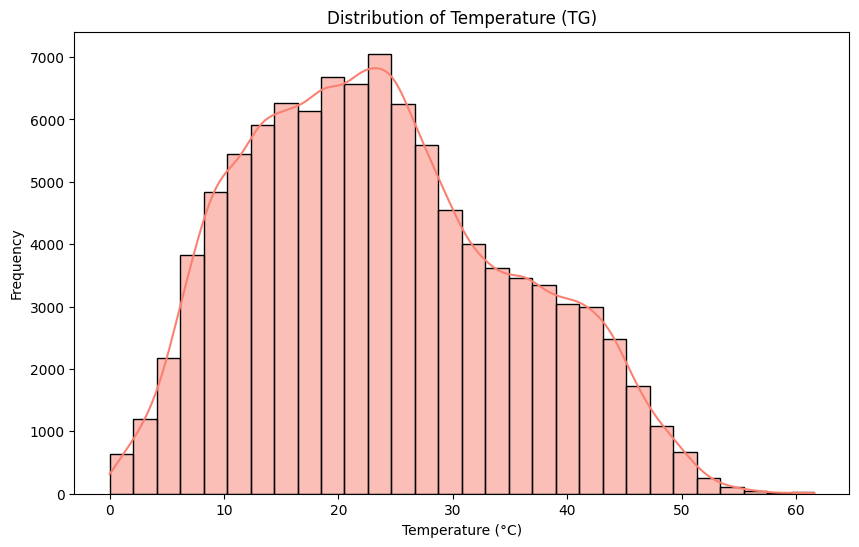

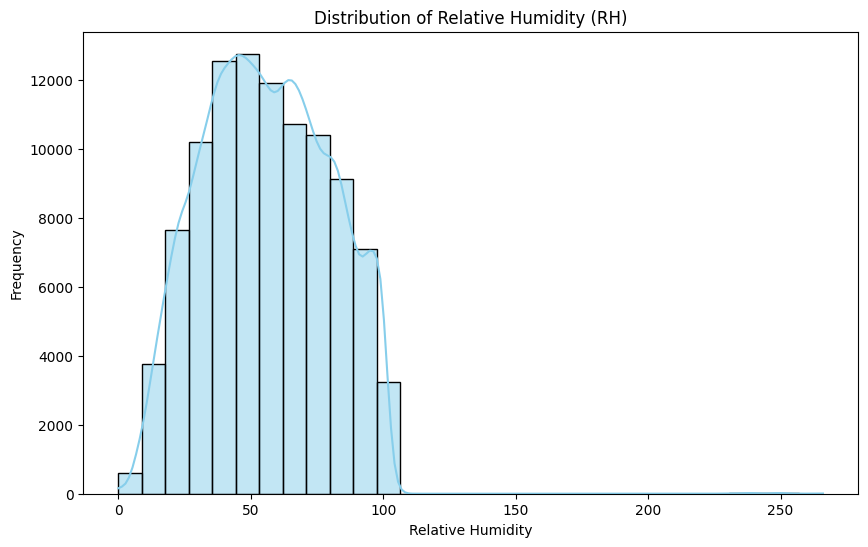

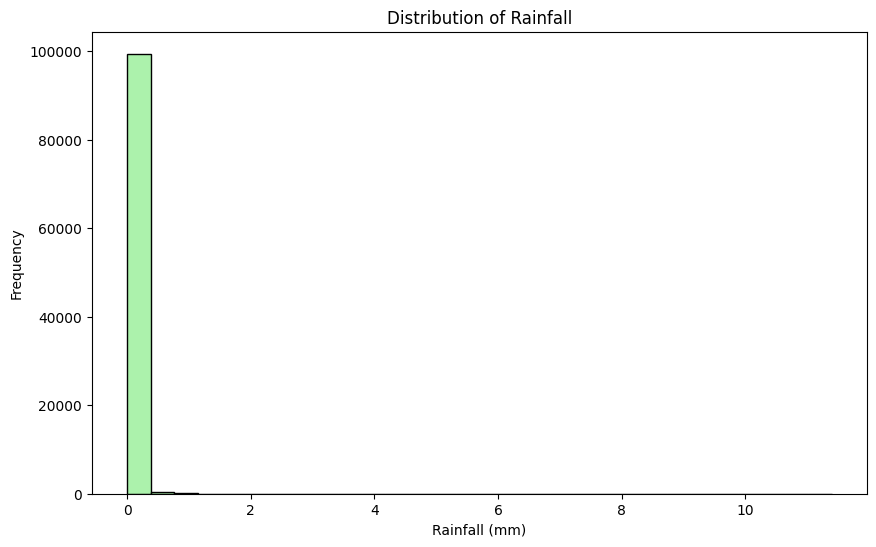

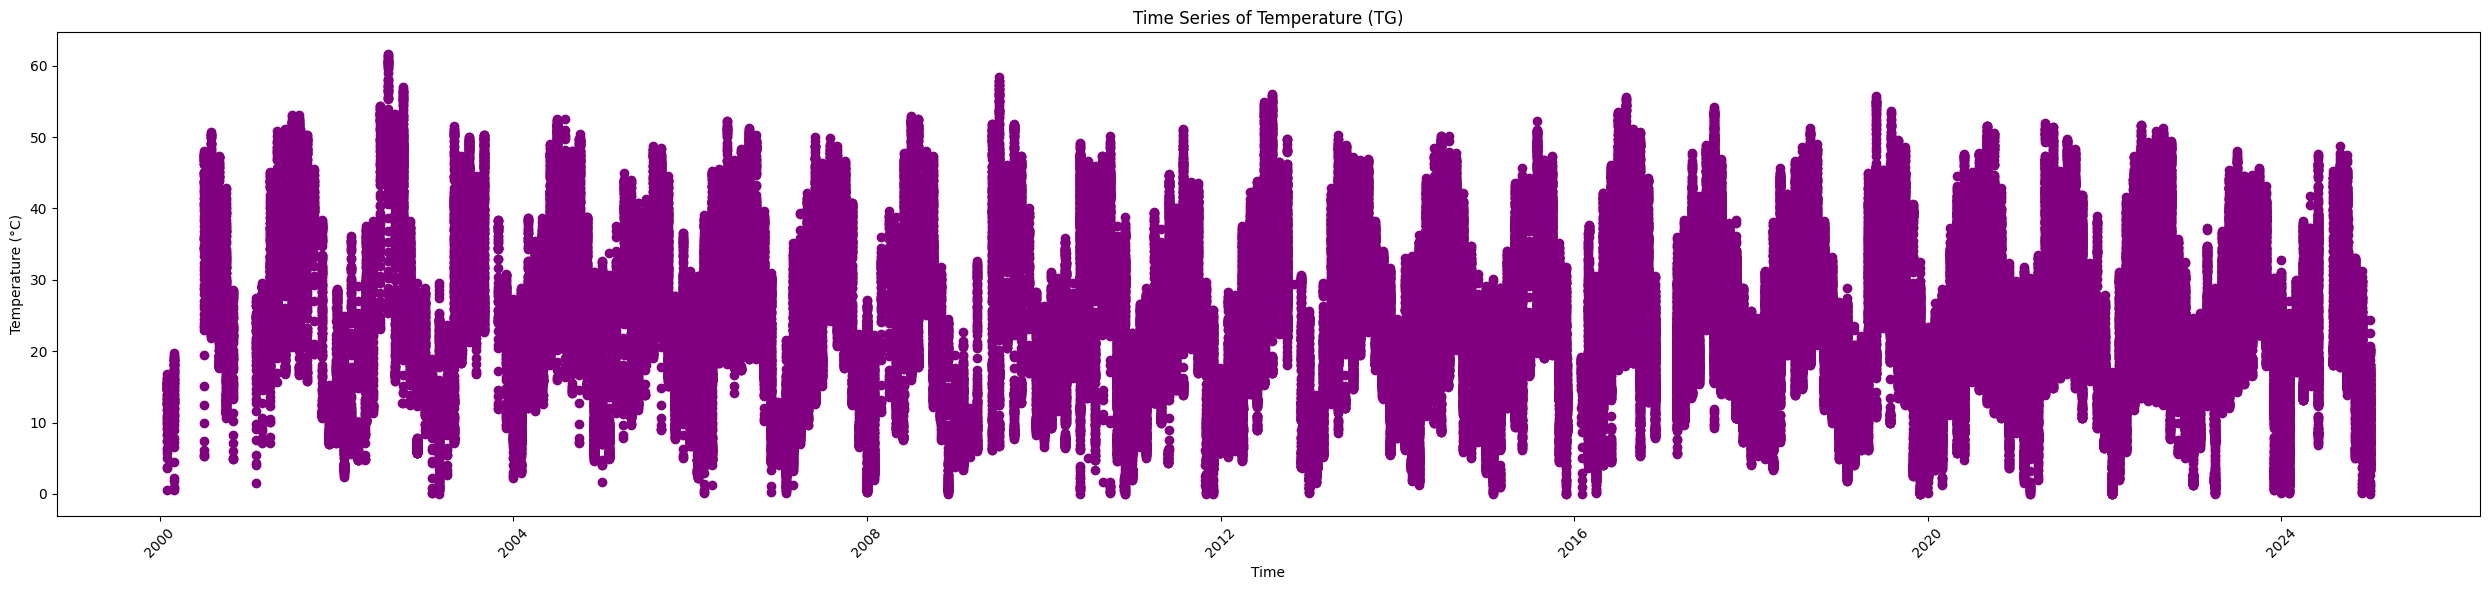

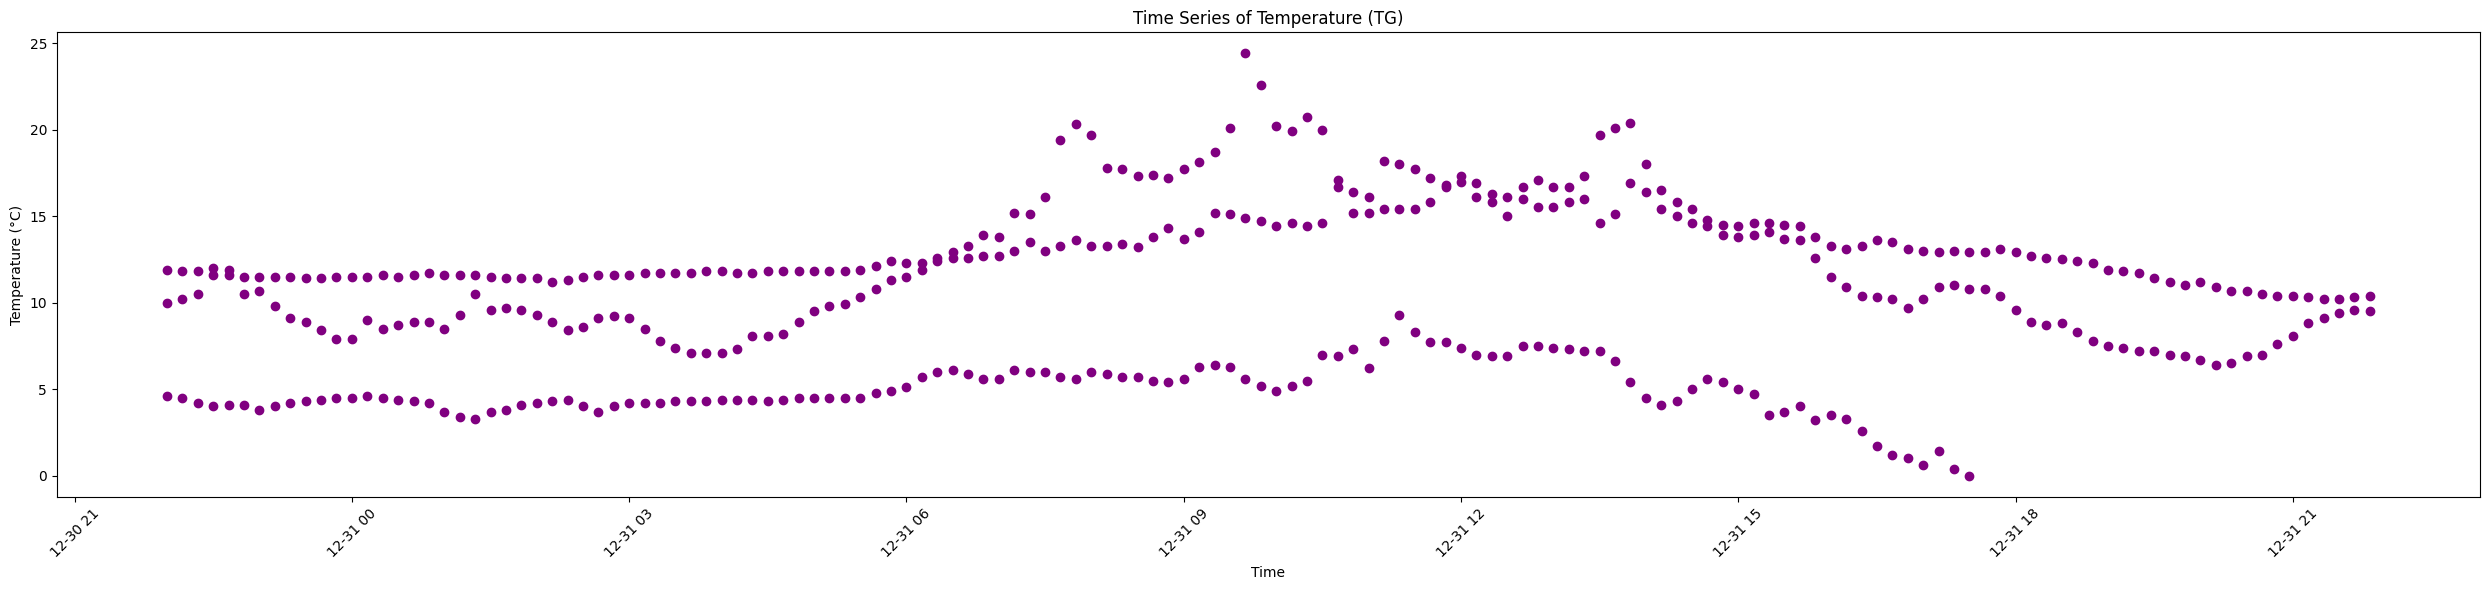

Initial shape of data: (99981, 21)
Using test_size=9998 (10.0% of dataset) with sequence_length=6 for forecast_horizon='hourly'.
Using test_size=9998 (10.0% of dataset)
(99981, 21)
(98959, 21)
Fold 1: TRAIN indices=[0..68964], TEST=[68965..78962]
Fold 2: TRAIN indices=[0..78962], TEST=[78963..88960]
Fold 3: TRAIN indices=[0..88960], TEST=[88961..98958]
Prepared 3 folds of data.

================= Fold 1 =================

--- Linear Regression ---

--- Training Linear Regression Model ---
Linear Regression Performance:
  MAE: 1.6505
  MSE: 5.9085
  R2: 0.9546
  MdAPE: 5.5257%



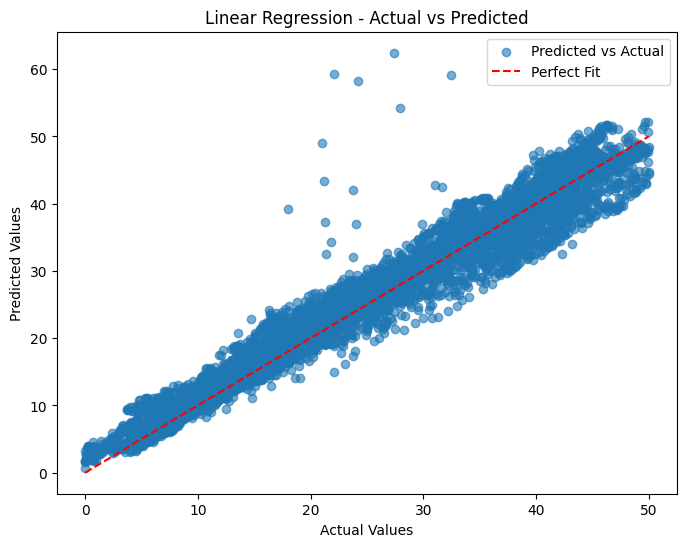

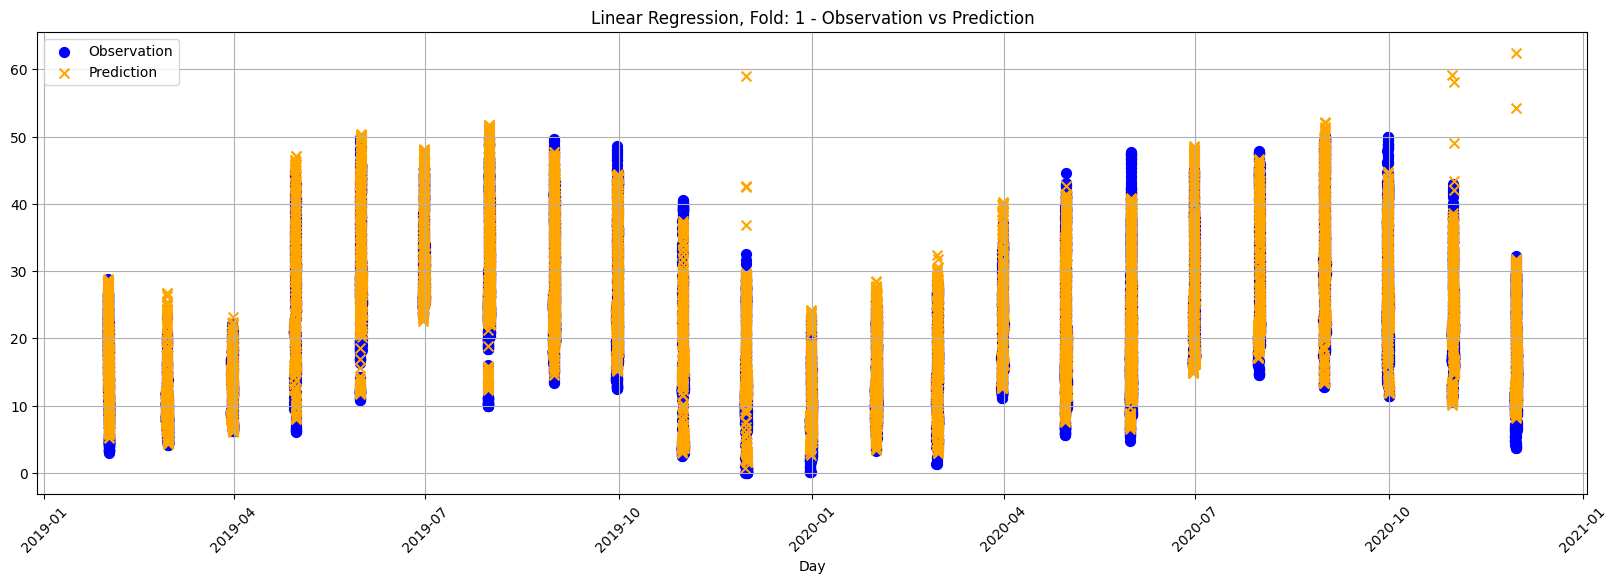

datetime
2019-01-31 05:50:00+00:00    12.4
2019-01-31 06:00:00+00:00    12.5
2019-01-31 06:00:00+00:00    14.8
2019-01-31 06:00:00+00:00    10.5
2019-01-31 06:00:00+00:00    11.6
Name: TG, dtype: float64


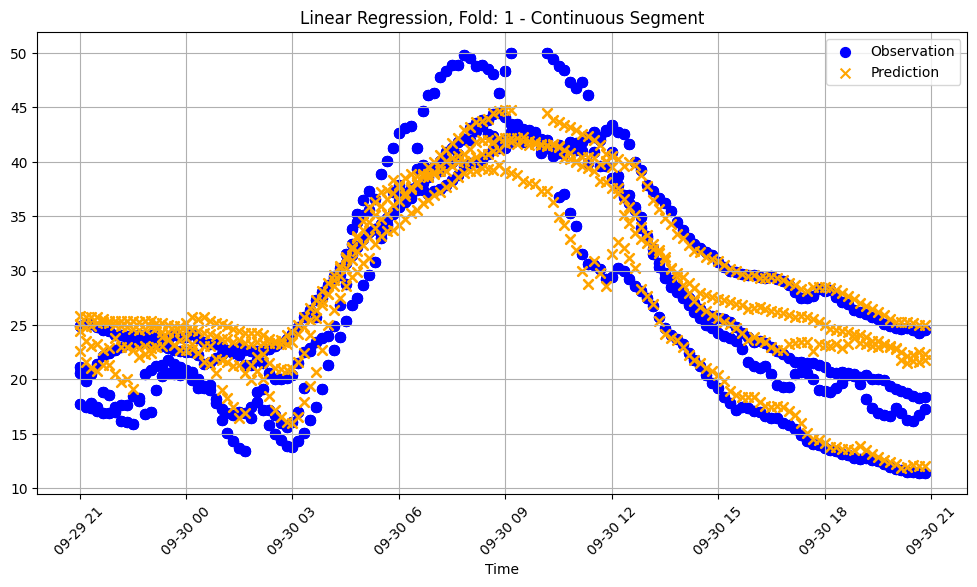

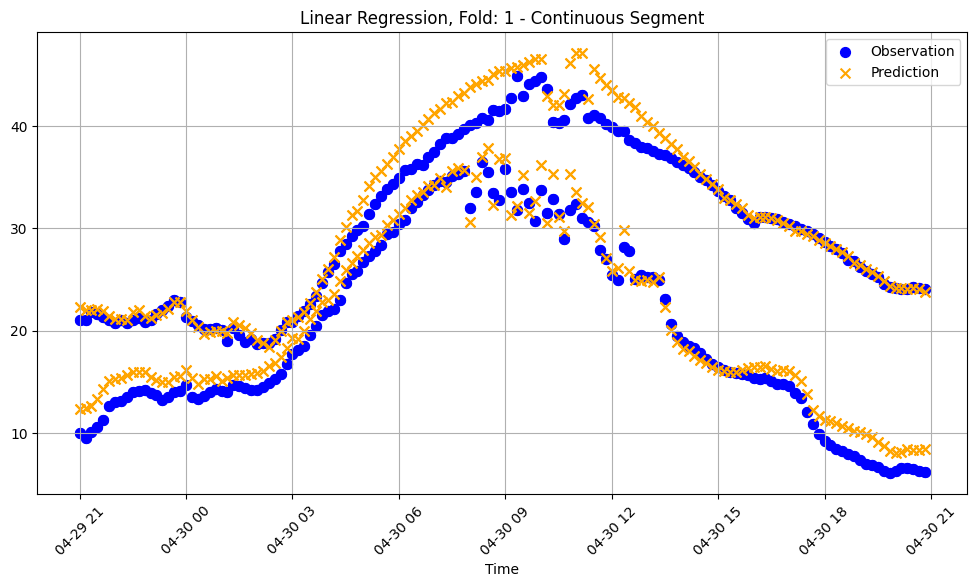

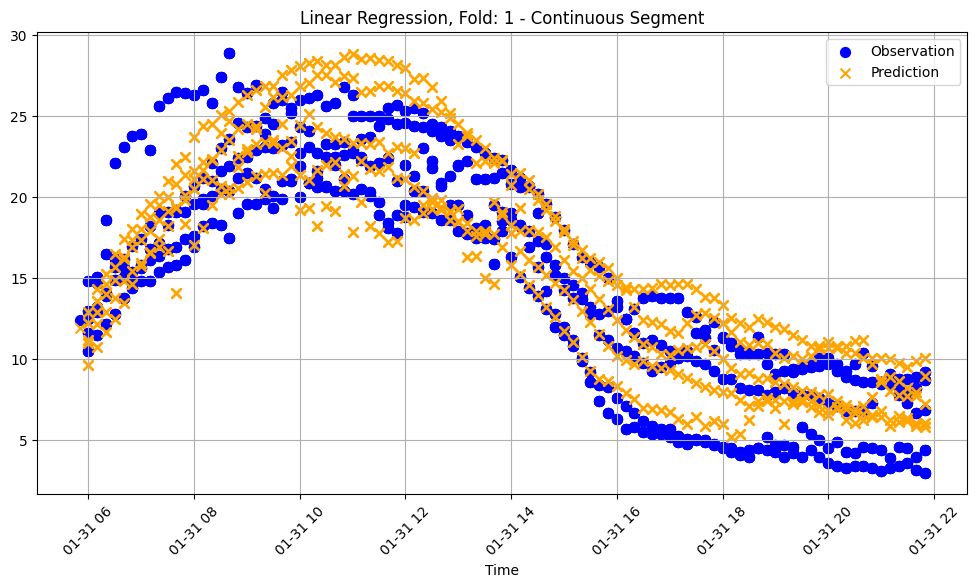


--- Ridge Regression ---

--- Training Ridge Regression Model ---
Ridge Regression Performance:
  MAE: 1.6481
  MSE: 5.8965
  R2: 0.9547
  MdAPE: 5.5042%



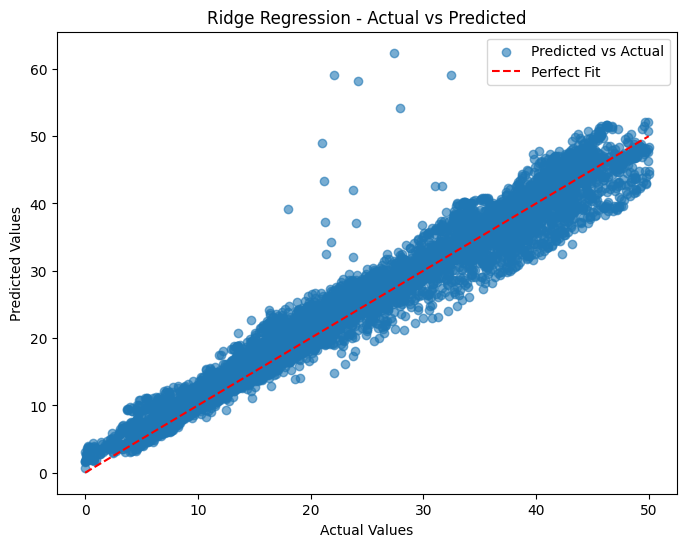

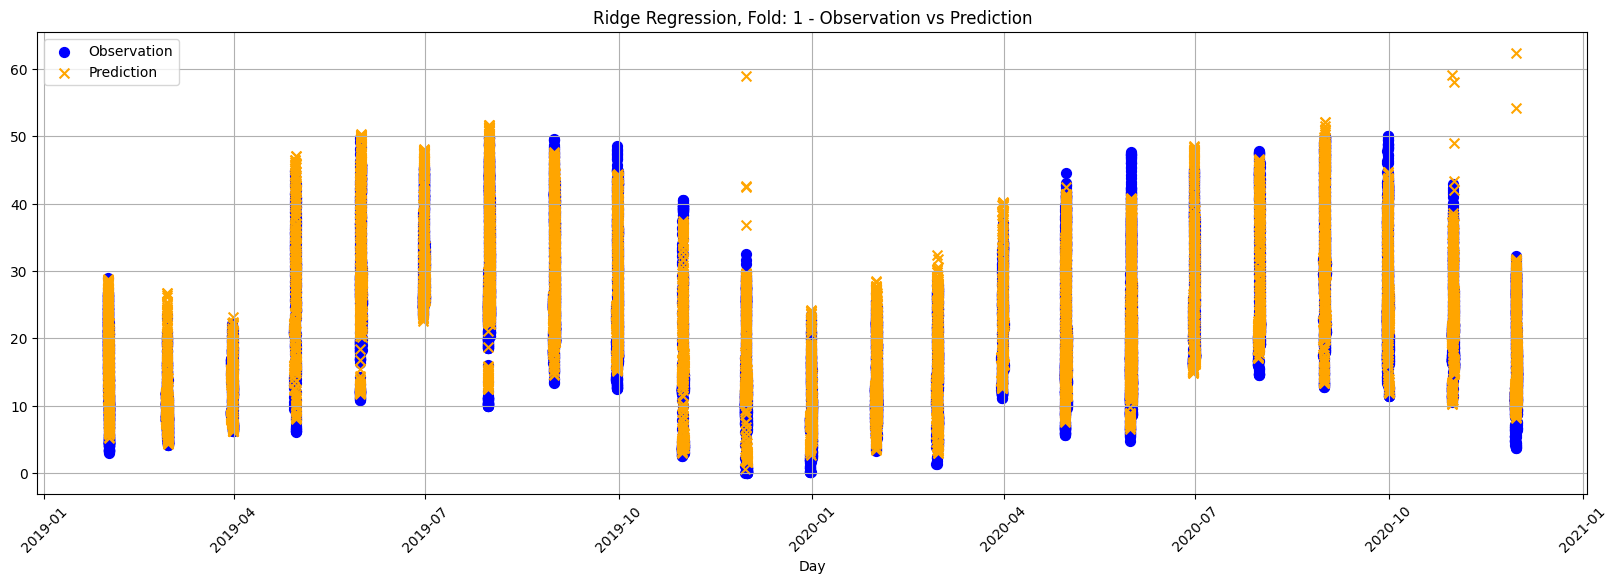

datetime
2019-01-31 05:50:00+00:00    12.4
2019-01-31 06:00:00+00:00    12.5
2019-01-31 06:00:00+00:00    14.8
2019-01-31 06:00:00+00:00    10.5
2019-01-31 06:00:00+00:00    11.6
Name: TG, dtype: float64


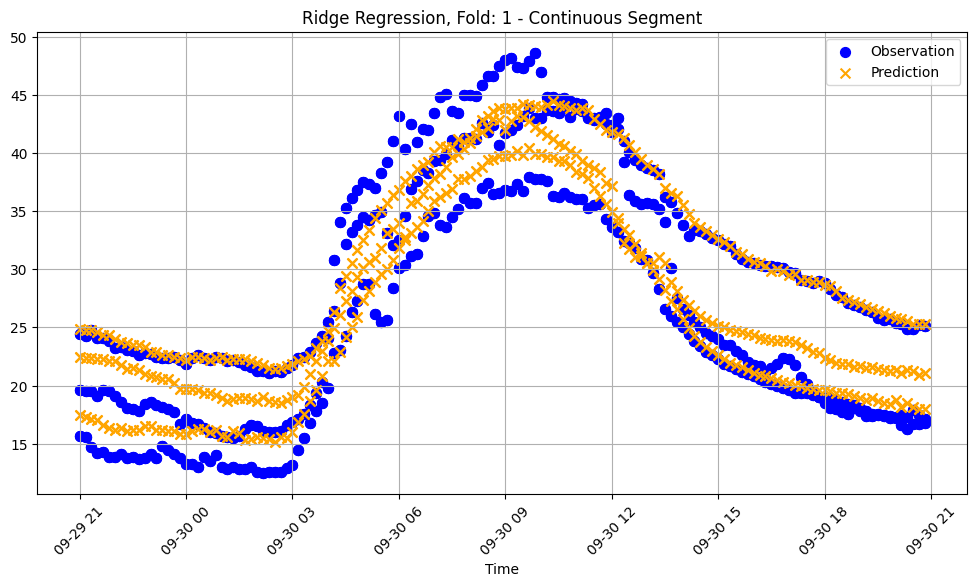

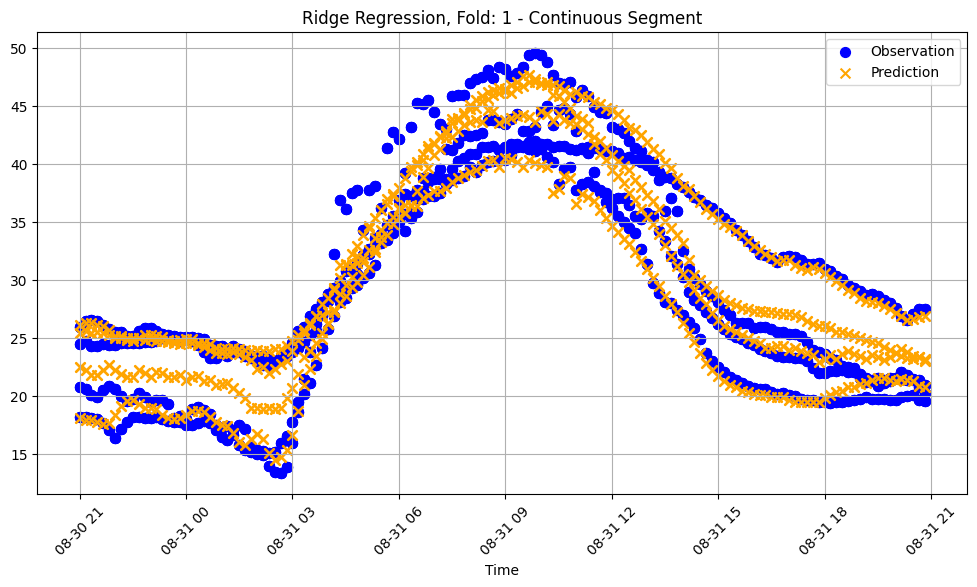

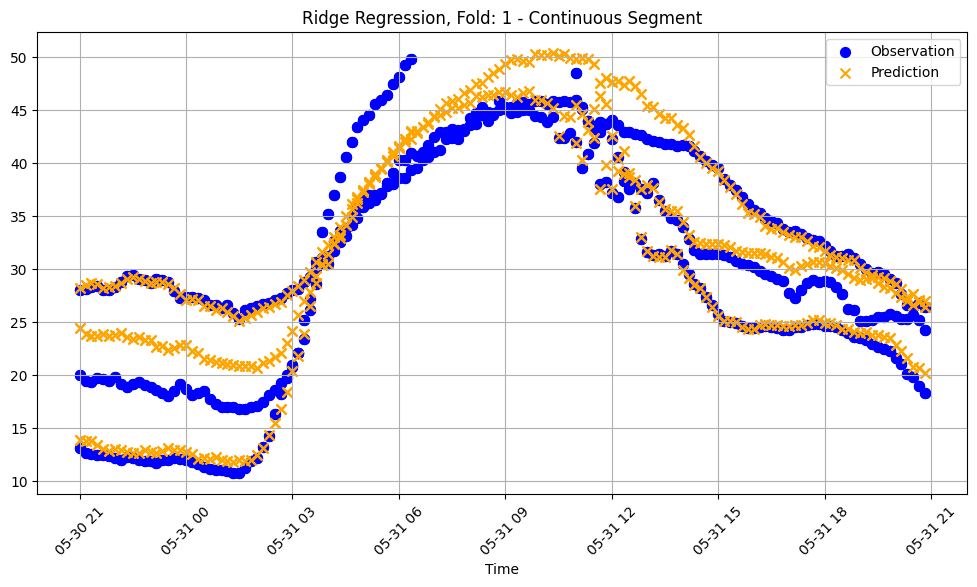


--- Lasso Regression ---

--- Training Lasso Regression Model ---
Lasso Regression Performance:
  MAE: 2.1509
  MSE: 8.0903
  R2: 0.9378
  MdAPE: 7.7903%



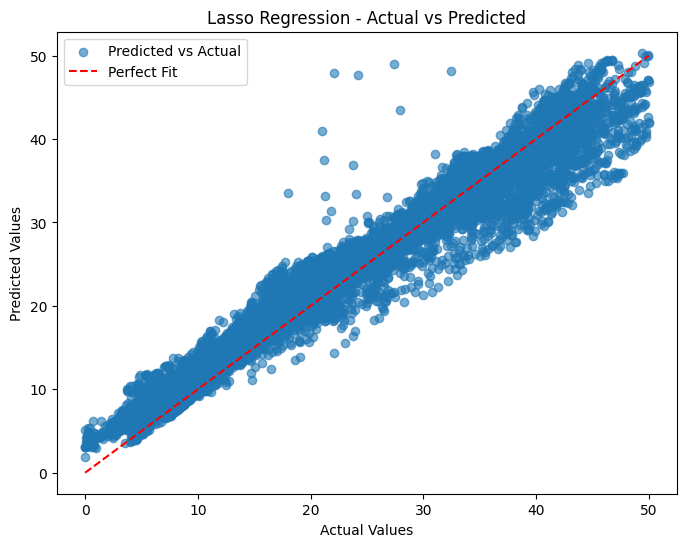

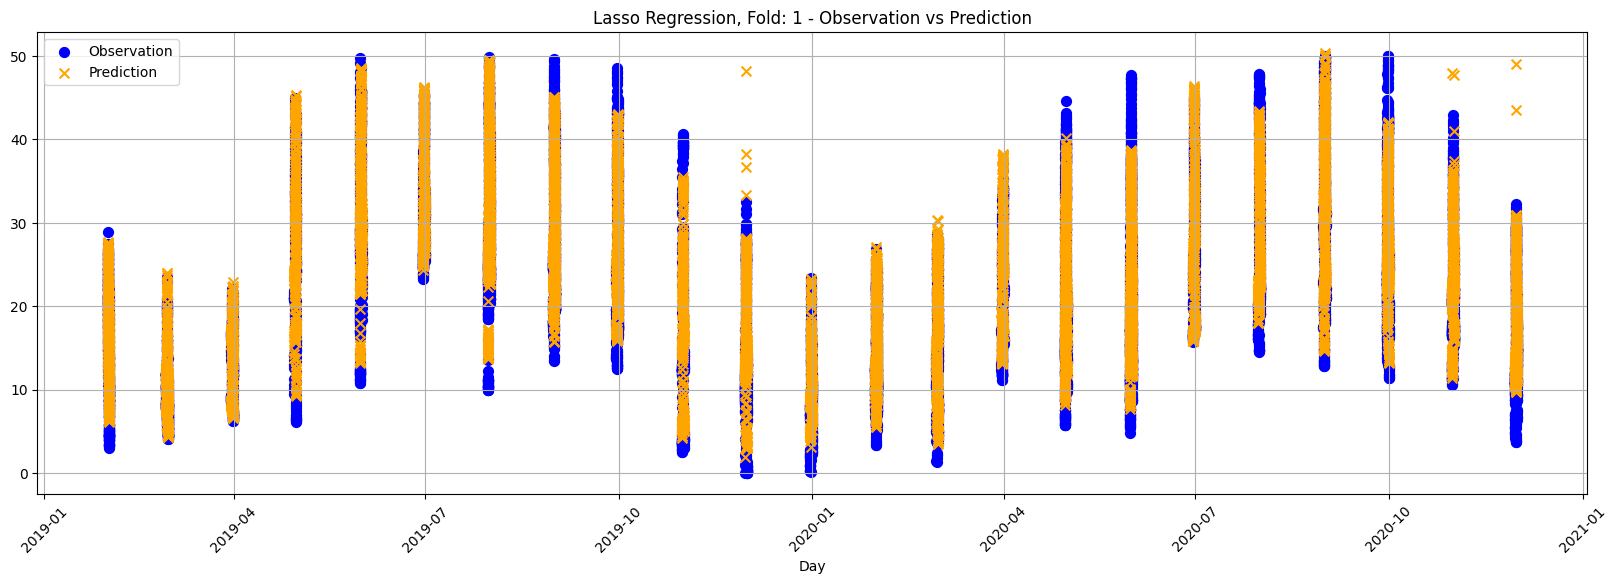

datetime
2019-01-31 05:50:00+00:00    12.4
2019-01-31 06:00:00+00:00    12.5
2019-01-31 06:00:00+00:00    14.8
2019-01-31 06:00:00+00:00    10.5
2019-01-31 06:00:00+00:00    11.6
Name: TG, dtype: float64


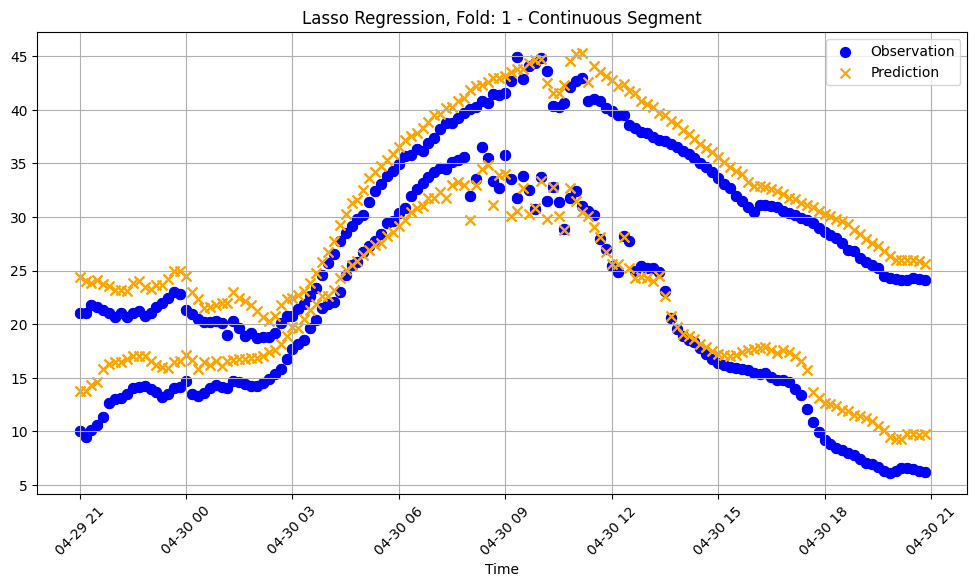

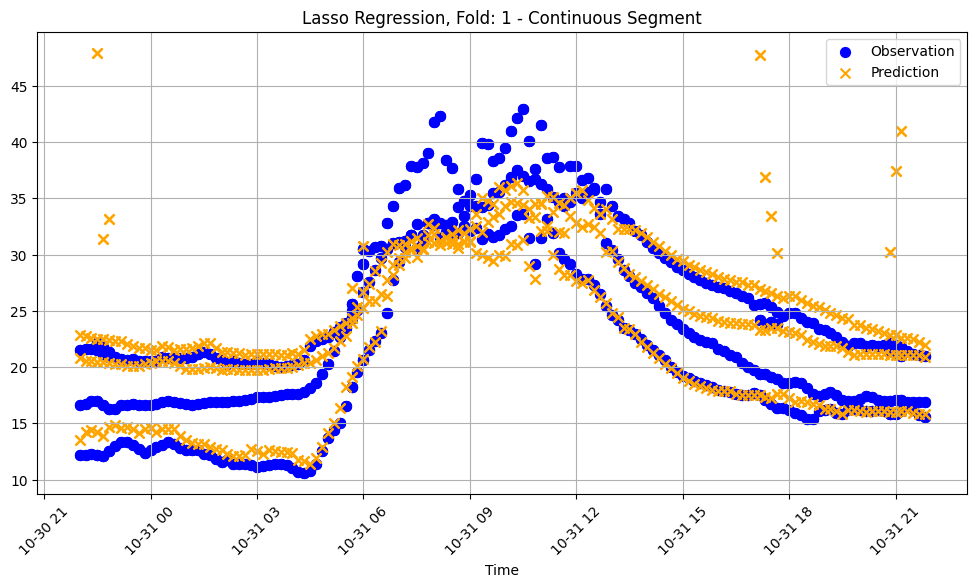

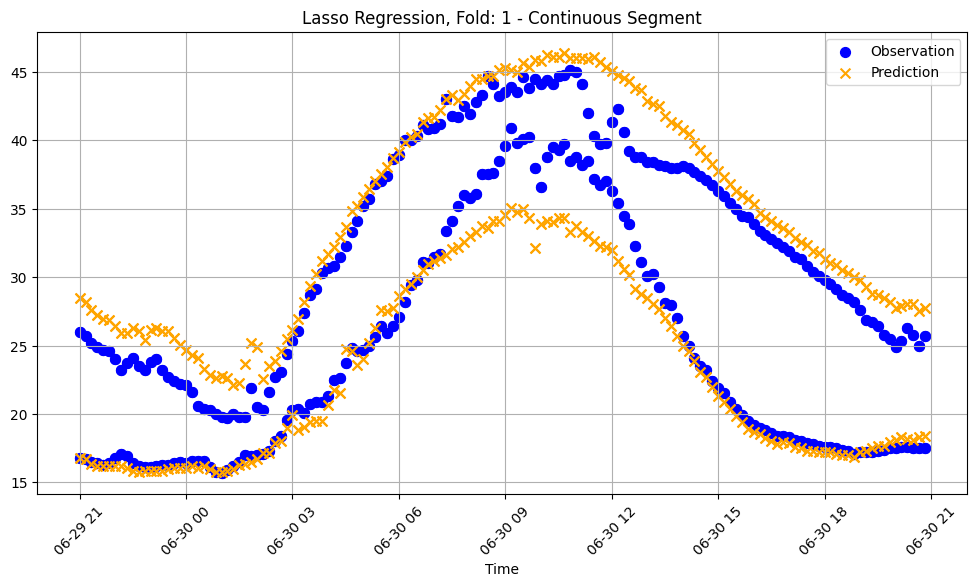


--- Random Forest ---

--- Training Random Forest Model ---
Random Forest Performance:
  MAE: 1.5144
  MSE: 4.8590
  R2: 0.9626
  MdAPE: 4.8780%



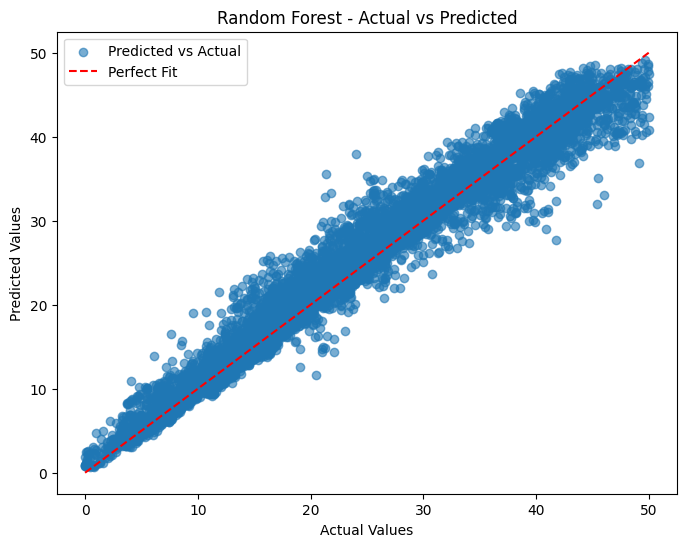

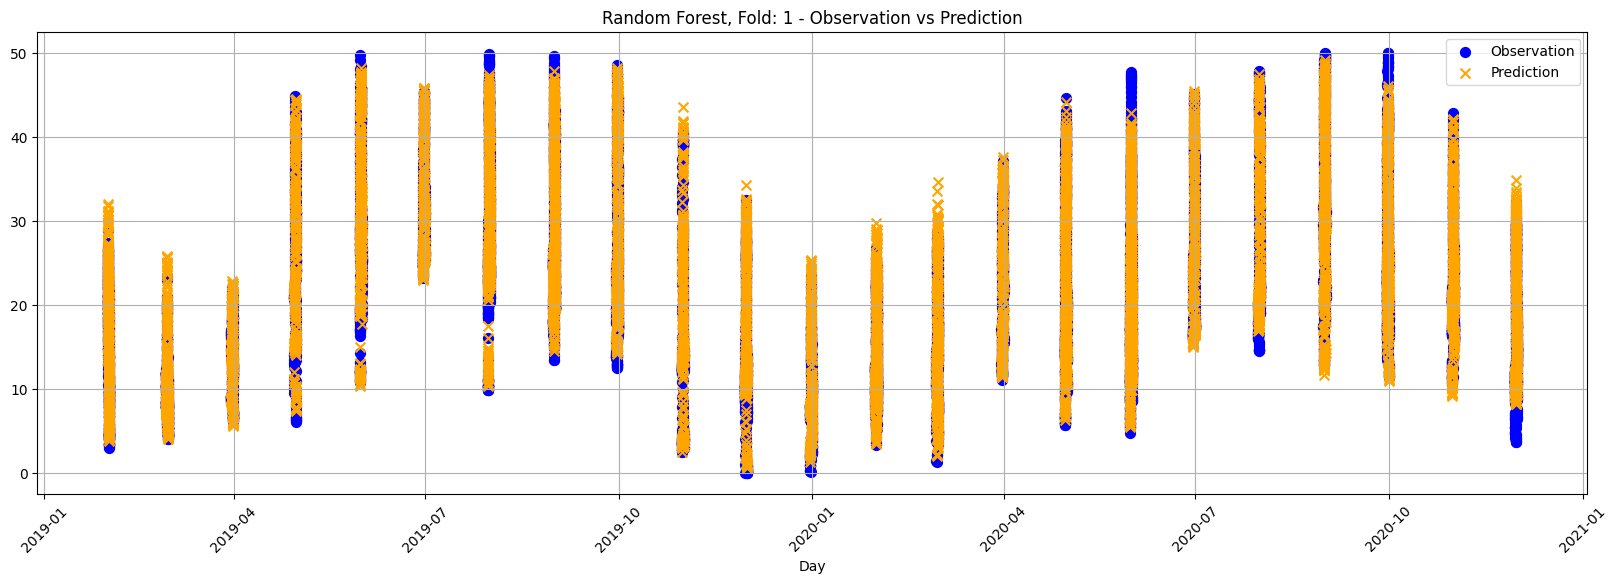

datetime
2019-01-31 05:50:00+00:00    12.4
2019-01-31 06:00:00+00:00    12.5
2019-01-31 06:00:00+00:00    14.8
2019-01-31 06:00:00+00:00    10.5
2019-01-31 06:00:00+00:00    11.6
Name: TG, dtype: float64


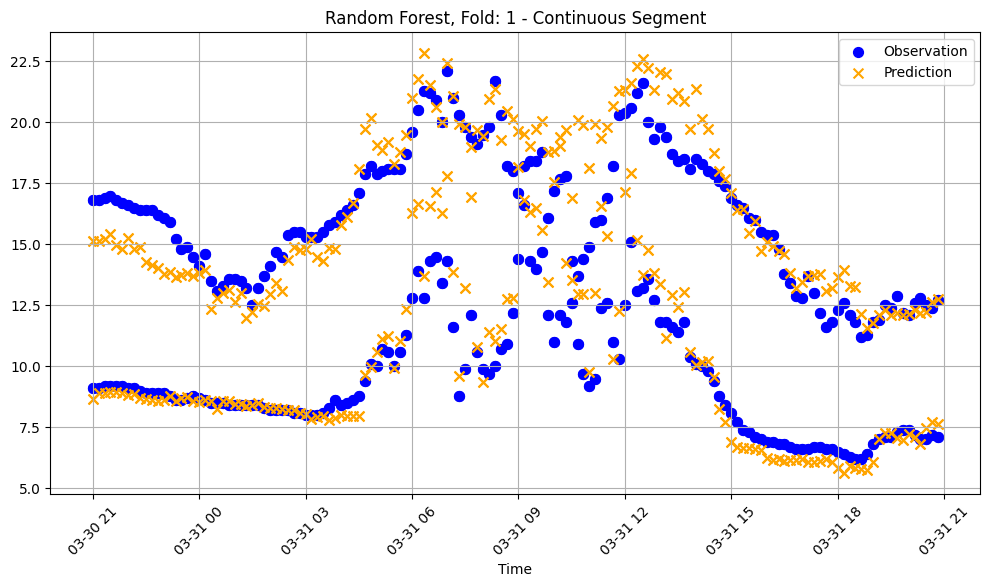

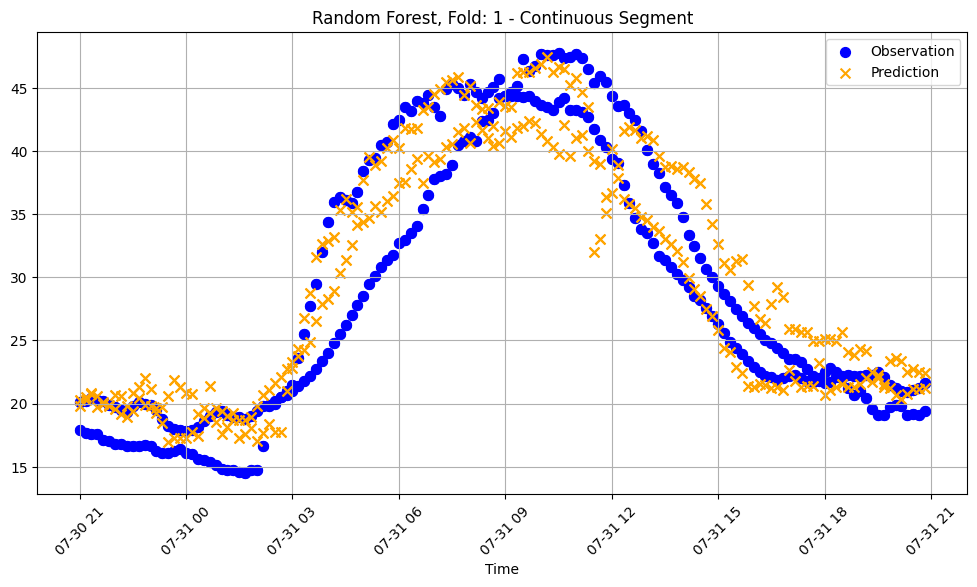

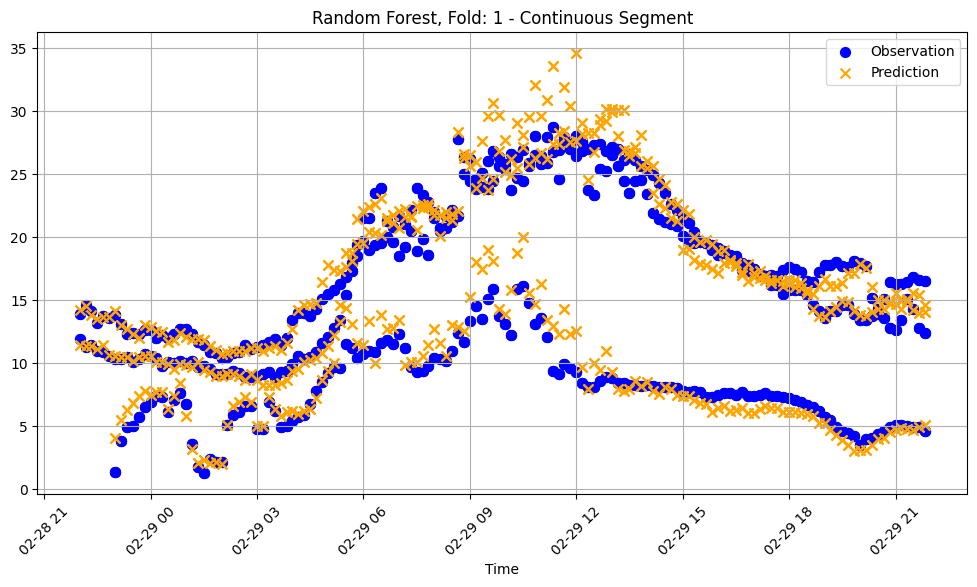


--- LSTM ---
LSTM Epoch 1/10 - Train Loss: 139.0896, Val Loss: 102.3877
New best LSTM model saved.
LSTM Epoch 2/10 - Train Loss: 135.1870, Val Loss: 103.6943
LSTM Epoch 3/10 - Train Loss: 135.0635, Val Loss: 102.3476
New best LSTM model saved.
LSTM Epoch 4/10 - Train Loss: 69.0504, Val Loss: 20.5988
New best LSTM model saved.


In [ ]:

# ------------------------------------------------------------------- #
#                             Entry Point
# ------------------------------------------------------------------- #
"""
A short recap on 'forecast_horizon':
    "hourly": 6,        # 1-hour (6 x 10-minute intervals)
    "short": 144,       # 1-day (144 x 10-minute intervals)
    "3-day": 432,       # 3 days (3 × 144)
    "weekly": 1008,     # 7 days (7 × 144)
    "10-day": 1440,     # 10 days (10 × 144)
    "bi-weekly": 2016,  # 14 days (14 × 144)
    "monthly": 4320,    # 30 days (30 × 144)
    "seasonal": 12960,  # 90 days (3 months × 30 days × 144)
    "yearly": 52560     # 1 year (365 × 144)
"""

if __name__ == "__main__":
  main(n_splits=3, test_size_ratio=0.1, forecast_horizon="hourly", y='TG')